# Соревнование для учащися курса "Специалист по работе с данными / Data Scientist". Школа 21 СБЕР / Томский государственный университет

https://www.kaggle.com/competitions/sber-21-tgu-2022/data

Задача - предсказать стоимость аренды квартир в Лондоне. Метрика - MAE.

# Предварительный анализ данных

In [2]:
import pandas as pd
import numpy as np
import re

# Calendar

In [2]:
calendar = pd.read_csv('calendar.csv',
                      index_col='listing_id',
                      true_values=['t'],
                      false_values=['f'],
                      parse_dates=['date'])
calendar

,date,available
listing_id,,
127860,2019-09-08,False
127860,2019-09-07,False
127860,2019-09-06,False
127860,2019-09-05,False
127860,2019-09-04,False
...,...,...
27182471,2018-11-09,False
27182471,2018-11-08,False
27182471,2018-11-07,False


In [3]:
calendar.groupby('listing_id', as_index=True).agg({'date': 'count'}).value_counts()

date
365     51815
dtype: int64

Для каждого из 51815 объектов есть информация по 365 дням. 

In [4]:
calendar.date.nunique()

368

Инервал для некоторых объектов слегка смещен.

In [5]:
calendar.groupby('date', as_index=True).agg({'available': 'count'})

,available
date,
2018-11-04,6620
2018-11-05,51814
2018-11-06,51814
2018-11-07,51815
2018-11-08,51815
...,...
2019-11-02,51815
2019-11-03,51815
2019-11-04,45195


In [6]:
calendar.groupby('date', as_index=True).agg({'available': 'count'}).value_counts()

available
51815        362
1              2
51814          2
6620           1
45195          1
dtype: int64

Доля свободных объектов в зависимости от времени

In [7]:
daily = calendar.groupby('date', as_index=True)\
    .agg({'available': 'sum'})

In [8]:
daily.describe()

,available
count,368.000000
mean,17066.657609
std,4132.356515
min,1.000000
25%,13985.000000
50%,14651.000000
75%,20203.250000
max,26652.000000


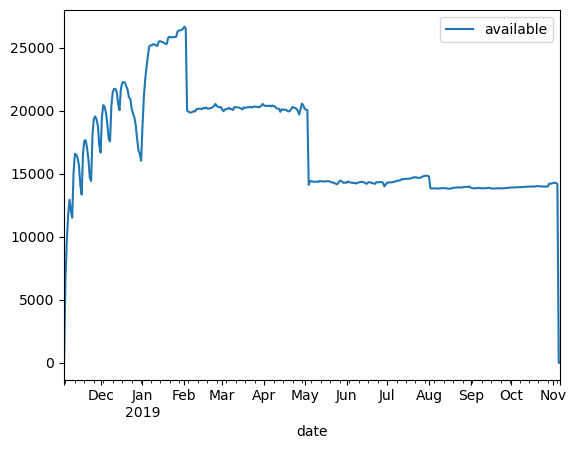

In [9]:
daily.plot.line();

Статистика по объектам

In [10]:
properties = calendar.groupby('listing_id').agg({'available': 'mean'})

In [11]:
properties.describe()

,available
count,51815.000000
mean,0.332084
std,0.359442
min,0.000000
25%,0.000000
50%,0.191781
75%,0.632877
max,1.000000


<AxesSubplot:ylabel='Density'>

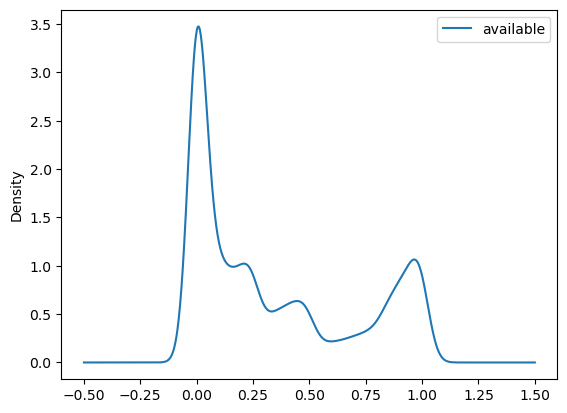

In [12]:
properties.plot.kde()

Явно видны "плохие" и "хорошие" объекты (и еще две промежуточные моды).

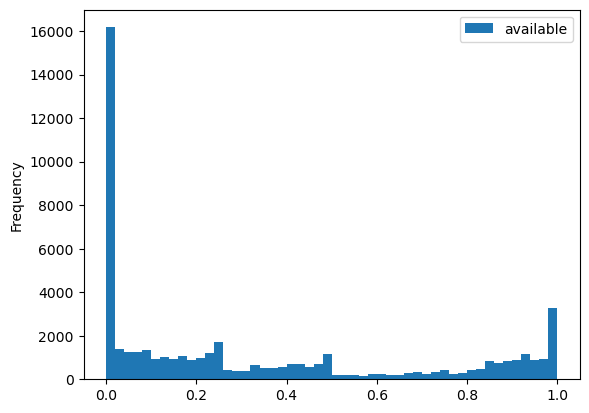

In [13]:
properties.plot.hist(bins=50);

Самое простое - использовать среднюю долю времени, когда объект был свободен, за год. Более сложный - придать больший вес времени, приближенному к концу года, хотя из условий задачи неизвестно, насколько близок этот год ко времени, на которое нужно дать прогноз. Поэтому пока использую средний показатель за год.

In [14]:
properties

,available
listing_id,
127860,0.000000
325809,1.000000
429045,1.000000
473637,0.000000
533943,0.994521
...,...
29797787,0.547945
29797809,0.479452
29797854,0.093151


In [58]:
properties.to_csv('calendar_availability.csv')

# Отзывы

In [131]:
reviews = pd.read_csv('reviews.csv',
                      parse_dates=['date'])
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,533943,16055746,2014-07-21,13007741,Paula,We were very happy with our stay at the Luxury...
1,882380,3619914,2013-02-26,3796804,Nancy,"Safia's apartments are gorgeous! Brand new, im..."
2,882380,8712673,2013-11-13,1812564,Barbara,Safia is an amazing hostess. She is attentive ...
3,882380,331776386,2018-10-03,27810796,Jessie,The host canceled this reservation 2 days befo...
4,1279956,5404576,2013-06-28,7004928,James,I really enjoyed staying at Julien’s place and...
...,...,...,...,...,...,...
501205,29735949,344807582,2018-11-04,27552372,Declan,"Clean, spacious, stylish apartment close to ev..."
501206,29736900,344387254,2018-11-03,109537206,Shazia,spotless clean flat with amazing view. the hos...
501207,29756033,344498174,2018-11-03,26000990,Andrea,The host canceled this reservation 55 days bef...
501208,29775194,345574439,2018-11-05,34546792,Robert,The host canceled this reservation 45 days bef...


In [69]:
reviews.loc[501209, 'comments']

'The host canceled this reservation 53 days before arrival. This is an automated posting.'

In [61]:
reviews.nunique()

listing_id        38220
id               501194
date               1054
reviewer_id      437622
reviewer_name     66921
comments         478048
dtype: int64

In [65]:
len(set(calendar.index).intersection(reviews.listing_id))

38220

In [90]:
set(reviews.listing_id).issubset(calendar.index)

True

Объекты отзывов - подмножество объектов файла с календарными данными.

In [102]:
reviews.groupby('listing_id').agg({'date': ['min', 'max', 'count']})

date                 
                  min        max count
listing_id                            
533943     2014-07-21 2014-07-21     1
882380     2013-02-26 2018-10-03     3
1279956    2013-06-28 2014-04-03     4
1665188    2015-07-15 2015-07-15     1
2617879    2015-08-04 2015-08-04     1
...               ...        ...   ...
29735949   2018-11-04 2018-11-04     1
29736900   2018-11-03 2018-11-03     1
29756033   2018-11-03 2018-11-03     1
29775194   2018-11-05 2018-11-05     1
29793575   2018-11-05 2018-11-05     1

[38220 rows x 3 columns]

Разные даты и интервалы, но, похоже, в основном короткие.

In [103]:
reviews.groupby('listing_id').agg({'date': 'count'}).value_counts()

date
1       6368
2       4156
3       3219
4       2594
5       2096
        ... 
165        1
148        1
146        1
143        1
310        1
Length: 200, dtype: int64

<AxesSubplot:ylabel='Frequency'>

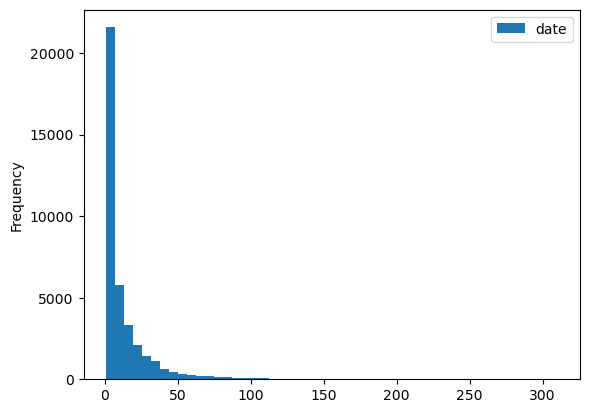

In [105]:
reviews.groupby('listing_id').agg({'date': 'count'}).plot.hist(bins=50)

Рейтинга нет. Стандартные методы классификации текстов не подходят. Вероятно, можно как-то кластеризовать отзывы. В этой версии пока не делал. 

Видно, что есть шаблонный комментарий об отмене. По каждому объекту выделяю информацию о среднем числе отмен и среднем времени уведомления до заезда в случае отмены, а также число отзывов.

In [132]:
reviews['canceled'] = reviews.comments.str.fullmatch('The host canceled this reservation \d+ days before arrival. This is an automated posting.')
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,canceled
0,533943,16055746,2014-07-21,13007741,Paula,We were very happy with our stay at the Luxury...,False
1,882380,3619914,2013-02-26,3796804,Nancy,"Safia's apartments are gorgeous! Brand new, im...",False
2,882380,8712673,2013-11-13,1812564,Barbara,Safia is an amazing hostess. She is attentive ...,False
3,882380,331776386,2018-10-03,27810796,Jessie,The host canceled this reservation 2 days befo...,True
4,1279956,5404576,2013-06-28,7004928,James,I really enjoyed staying at Julien’s place and...,False
...,...,...,...,...,...,...,...
501205,29735949,344807582,2018-11-04,27552372,Declan,"Clean, spacious, stylish apartment close to ev...",False
501206,29736900,344387254,2018-11-03,109537206,Shazia,spotless clean flat with amazing view. the hos...,False
501207,29756033,344498174,2018-11-03,26000990,Andrea,The host canceled this reservation 55 days bef...,True
501208,29775194,345574439,2018-11-05,34546792,Robert,The host canceled this reservation 45 days bef...,True


In [136]:
tmp = reviews.comments.str\
.extract('(?P<start>The host canceled this reservation )(?P<notice>\d+)(?P<end> days before arrival. This is an automated posting.)',
        expand=True)

In [140]:
tmp.notice.to

0         NaN
1         NaN
2         NaN
3           2
4         NaN
         ... 
501205    NaN
501206    NaN
501207     55
501208     45
501209     53
Name: notice, Length: 501210, dtype: object

In [143]:
reviews['notice'] = tmp.notice.astype(float)

In [145]:
reviews.notice.mean()

33.895029108822214

In [147]:
reviews_stat = reviews.groupby('listing_id').agg({'comments': 'count', 'canceled': 'mean', 'notice': 'mean'})
reviews_stat

,comments,canceled,notice
listing_id,,,
533943,1,0.000000,NaN
882380,3,0.333333,2.0
1279956,4,0.000000,NaN
1665188,1,0.000000,NaN
2617879,1,0.000000,NaN
...,...,...,...
29735949,1,0.000000,NaN
29736900,1,0.000000,NaN
29756033,1,1.000000,55.0


In [148]:
reviews_stat.notice.mean()

33.216307166177586

In [149]:
reviews_stat.to_csv('reviews_stat.csv')

# Main dataset

In [3]:
train = pd.read_csv('train.csv',
                    index_col='id',
                    true_values=['t'],
                    false_values=['f'],
                    parse_dates=['host_since'])
train

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,...,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
id,,,,,,,,,,,,,,,,,,,,,
20145777,Double in a friendly house,A double bedroom in a cozy and modern apartm...,NaN,A double bedroom in a cozy and modern apartm...,none,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0.0,1,flexible,False,False,90.0
22630537,London flat with great transport links,"Light, airy and modern one bedroom flat 2 mins...",NaN,"Light, airy and modern one bedroom flat 2 mins...",none,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25.0,2,20.0,1,moderate,False,False,75.0
27355619,"Studio Apartments, 5 mins to Kings Cross Station!","Based in high quality student accommodation, o...",What To Expect: * 16/17m2 Studio with modern f...,"Based in high quality student accommodation, o...",none,As one of Central London’s most vibrant and ne...,• Do you have free WiFi? Yes we have super fas...,You will be in an incredible position for gett...,"You will enjoy your own studio, with a private...",Our reception can help you out with anything y...,...,NaN,80.0,45.0,1,0.0,3,flexible,False,False,89.0
21011236,"Big, Beautiful, Sunny, West Kensington TWIN Room","Big Beautiful, airy, West Kensington TWIN room...",This is a pretty terraced house in a great are...,"Big Beautiful, airy, West Kensington TWIN room...",none,We’re in a fantastic location - close to many ...,We lay on a good breakfast that guests serve t...,NaN,The room is exclusively yours while you're her...,I'm Matthew and I live here with my son Alex. ...,...,NaN,NaN,12.0,1,11.0,1,moderate,False,False,60.0
24754494,Dashing 1BR in Bayswater by Sonder,"At this Sonder, you'll love the chic decor, st...",Every booking is instantly confirmed. Every ca...,"At this Sonder, you'll love the chic decor, st...",none,"Your Sonder is in a beautiful dwelling, conver...","This Sonder does not have air conditioning, bu...",Your Sonder is located at the end of a cul-de-...,NaN,"Our concierge is available by phone, email, or...",...,NaN,300.0,63.0,2,5.0,2,strict_14_with_grace_period,False,False,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18151315,Sunny studio with private kitchen and bathroom,"Quiet, sunny studio flat just minutes from the...",A small and very cosy flat with all necessary ...,"Quiet, sunny studio flat just minutes from the...",none,Crystal Palace is a vibrant bohemian oasis sur...,NaN,"2 mins to Gipsy Hill Rail, direct links to Vi...",You have shared access through main front door...,I have an apartment manager who lives close by...,...,NaN,NaN,25.0,1,0.0,2,moderate,False,False,65.0
28105053,A comfy double room in modern flat ★ Haggerston,It's a double room for 2 guests.,NaN,It's a double room for 2 guests. I will be at ...,none,NaN,NaN,There is Haggerston overground station only 3 ...,NaN,I will be at the Airbnb to greet you and check...,...,NaN,0.0,10.0,1,10.0,2,strict_14_with_grace_period,False,False,31.0
26342100,Goldsborough House - Apartment London SW8,"Spacious three bedroom flat, fantastic locatio...",NaN,"Spacious three bedroom flat, fantastic locatio...",none,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0.0,1,flexible,False,False,150.0


In [11]:
train.dtypes

name                                        object
summary                                     object
space                                       object
description                                 object
experiences_offered                         object
neighborhood_overview                       object
notes                                       object
transit                                     object
access                                      object
interaction                                 object
house_rules                                 object
host_id                                      int64
host_since                          datetime64[ns]
host_about                                  object
host_response_time                          object
host_response_rate                          object
host_is_superhost                           object
host_has_profile_pic                        object
host_identity_verified                      object
neighbourhood_cleansed         

In [28]:
train.isna().sum(axis=0)

name                                    4
summary                              1264
space                               12918
description                           721
experiences_offered                     0
neighborhood_overview               15101
notes                               22652
transit                             15413
access                              16399
interaction                         17277
house_rules                         16585
host_id                                 0
host_since                              6
host_about                          16537
host_response_time                  14507
host_response_rate                  14508
host_is_superhost                       6
host_has_profile_pic                    6
host_identity_verified                  6
neighbourhood_cleansed                  0
zipcode                              1020
latitude                                0
longitude                               0
is_location_exact                 

## Numeric data

In [16]:
train.host_id

id
20145777    141917708
22630537     76064729
27355619    205450683
21011236    144406049
24754494     12243051
              ...    
18151315     41146181
28105053     58143804
26342100     37766192
13833612     16318656
19640194     49851295
Name: host_id, Length: 36270, dtype: int64

This feature will need to be deleted

In [17]:
train.host_since

id
20145777   2017-07-22
22630537   2016-06-06
27355619   2018-07-27
21011236   2017-08-05
24754494   2014-02-14
              ...    
18151315   2015-08-11
28105053   2016-02-10
26342100   2015-07-07
13833612   2014-06-03
19640194   2015-11-25
Name: host_since, Length: 36270, dtype: datetime64[ns]

In [27]:
train.host_since.astype(np.int64)

id
20145777    1500681600000000000
22630537    1465171200000000000
27355619    1532649600000000000
21011236    1501891200000000000
24754494    1392336000000000000
                   ...         
18151315    1439251200000000000
28105053    1455062400000000000
26342100    1436227200000000000
13833612    1401753600000000000
19640194    1448409600000000000
Name: host_since, Length: 36270, dtype: int64

In [24]:
train.bedrooms

id
20145777    1.0
22630537    1.0
27355619    0.0
21011236    1.0
24754494    1.0
           ... 
18151315    0.0
28105053    1.0
26342100    3.0
13833612    1.0
19640194    2.0
Name: bedrooms, Length: 36270, dtype: float64

In [30]:
train.select_dtypes('number').corr()

,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,price
host_id,1.000000,-0.006615,0.011263,-0.019624,-0.009504,-0.051792,-0.006734,-0.433868,-0.070166,-0.043910,-0.030037,-0.022034,-0.017552,0.013515
latitude,-0.006615,1.000000,0.105108,-0.016835,-0.013759,-0.040405,-0.016949,-0.435876,-0.016497,-0.033283,-0.001636,-0.002695,0.004489,-0.013357
longitude,0.011263,0.105108,1.000000,-0.044382,-0.061475,-0.057461,-0.046625,-0.496011,-0.077984,-0.120341,-0.023878,0.013416,-0.009715,-0.062955
accommodates,-0.019624,-0.016835,-0.044382,1.000000,0.487429,0.758379,0.826739,0.271045,0.228556,0.512988,0.502067,0.123750,0.006191,0.329969
bathrooms,-0.009504,-0.013759,-0.061475,0.487429,1.000000,0.558504,0.485813,0.536934,0.240958,0.430132,0.276193,0.051565,0.023910,0.263401
bedrooms,-0.051792,-0.040405,-0.057461,0.758379,0.558504,1.000000,0.737262,0.519631,0.259121,0.534309,0.406395,0.076911,0.028180,0.303149
beds,-0.006734,-0.016949,-0.046625,0.826739,0.485813,0.737262,1.000000,0.005974,0.203778,0.445477,0.441785,0.099926,0.013325,0.275765
square_feet,-0.433868,-0.435876,-0.496011,0.271045,0.536934,0.519631,0.005974,1.000000,0.788211,0.749110,-0.040329,0.114839,0.659296,0.707686
security_deposit,-0.070166,-0.016497,-0.077984,0.228556,0.240958,0.259121,0.203778,0.788211,1.000000,0.355245,0.147298,0.093745,0.135433,0.312777
cleaning_fee,-0.043910,-0.033283,-0.120341,0.512988,0.430132,0.534309,0.445477,0.749110,0.355245,1.000000,0.383496,0.029282,0.079605,0.420129


Столбец host_id будет удален. Долгота и широта не коррелируют с другими признаками. У остальных признаков есть корреляция, что может быть использовано при заполнении пропущенных значений.

## Categorical data

In [12]:
train.select_dtypes(include='object').nunique()

name                      35455
summary                   32893
space                     21687
description               34135
experiences_offered           3
neighborhood_overview     17577
notes                     10687
transit                   18230
access                    14556
interaction               13295
house_rules               14211
host_about                11623
host_response_time            4
host_response_rate           72
host_is_superhost             2
host_has_profile_pic          2
host_identity_verified        2
neighbourhood_cleansed       33
zipcode                   18738
property_type                37
room_type                     3
bed_type                      5
amenities                 33174
cancellation_policy           6
dtype: int64

In [5]:
train.experiences_offered.unique()

array(['none', 'business', 'romantic'], dtype=object)

Преобразовать 'none' в NaN

In [8]:
train.house_rules

id
20145777    I have a "No shoe" policy in the house. When m...
22630537                                                  NaN
27355619                                                  NaN
21011236    The room is for a maximum of two people and on...
24754494    House Rules 1. All bookings require a security...
                                  ...                        
18151315    - Quiet hours between 11pm and 6am please Stri...
28105053    Please note the following rules are set to giv...
26342100                             - Quiet hours 11pm - 6am
13833612    - Please treat this flat (my home) as you woul...
19640194                                                  NaN
Name: house_rules, Length: 36270, dtype: object

In [13]:
train.host_about

id
20145777                                                  NaN
22630537                                                  NaN
27355619                                                  NaN
21011236    My name's Matt and I live in the house with my...
24754494    Sonder provides everything you need for an exc...
                                  ...                        
18151315    Myself and my husband are professional people....
28105053                                                  NaN
26342100                                                  NaN
13833612    Hi there, my name is Sybille. I think my flat ...
19640194    "Made it with Passion - Treat it with Care" - ...
Name: host_about, Length: 36270, dtype: object

In [4]:
train.property_type

id
20145777             Apartment
22630537             Apartment
27355619    Serviced apartment
21011236             Townhouse
24754494             Apartment
                   ...        
18151315             Apartment
28105053             Apartment
26342100             Apartment
13833612             Apartment
19640194             Townhouse
Name: property_type, Length: 36270, dtype: object

Нужно преобразовать в число:

In [15]:
train.host_response_rate

id
20145777     NaN
22630537     40%
27355619    100%
21011236     NaN
24754494     98%
            ... 
18151315    100%
28105053    100%
26342100     NaN
13833612    100%
19640194    100%
Name: host_response_rate, Length: 36270, dtype: object

Можно поменять тип на bool у следущих колонок, хотя это и не обязательно.

In [17]:
train.host_is_superhost

id
20145777    False
22630537    False
27355619     True
21011236    False
24754494    False
            ...  
18151315    False
28105053    False
26342100    False
13833612    False
19640194    False
Name: host_is_superhost, Length: 36270, dtype: object

In [19]:
train.host_has_profile_pic

id
20145777    True
22630537    True
27355619    True
21011236    True
24754494    True
            ... 
18151315    True
28105053    True
26342100    True
13833612    True
19640194    True
Name: host_has_profile_pic, Length: 36270, dtype: object

In [20]:
train.host_identity_verified

id
20145777    False
22630537    False
27355619    False
21011236    False
24754494    False
            ...  
18151315     True
28105053     True
26342100    False
13833612     True
19640194    False
Name: host_identity_verified, Length: 36270, dtype: object

Почтовый индекс можно удалить, т.к. есть долгота и широта.

In [21]:
train.neighbourhood_cleansed

id
20145777                   Hackney
22630537                Wandsworth
27355619                 Islington
21011236    Hammersmith and Fulham
24754494               Westminster
                     ...          
18151315                   Lambeth
28105053                   Hackney
26342100                   Lambeth
13833612             Tower Hamlets
19640194                    Merton
Name: neighbourhood_cleansed, Length: 36270, dtype: object

In [23]:
train.amenities

id
20145777    {TV,Wifi,Kitchen,"Buzzer/wireless intercom",He...
22630537    {TV,"Cable TV",Wifi,Kitchen,"Pets allowed",Bre...
27355619    {TV,Wifi,Kitchen,Elevator,Heating,Washer,Dryer...
21011236    {TV,Wifi,Kitchen,"Paid parking off premises",B...
24754494    {TV,"Cable TV",Wifi,Kitchen,Heating,Washer,Dry...
                                  ...                        
18151315    {Wifi,Kitchen,Breakfast,"Free street parking",...
28105053    {"Cable TV",Wifi,Kitchen,"Paid parking off pre...
26342100    {TV,Wifi,Kitchen,"Paid parking off premises",E...
13833612    {TV,Internet,Wifi,"Wheelchair accessible",Kitc...
19640194    {TV,Wifi,Kitchen,"Free parking on premises",He...
Name: amenities, Length: 36270, dtype: object

In [25]:
train.amenities.apply(len).describe()

count    36270.000000
mean       270.361566
std        148.398118
min          2.000000
25%        169.000000
50%        239.000000
75%        339.000000
max       1652.000000
Name: amenities, dtype: float64

In [26]:
train.amenities.isna().sum()

0

Списки удобств очень большие. Можно оставить только количество, либо попытаться выбрать наиболее важные. В этой версии ограничимся числом.

Общий подход к категориальным признакам: оставляю все значения, если их немного (<10). Если много, то только две категории: есть данные или нет данных.

Оставлять ли название района (33 варианта) и тип объекта (37 вариантов)? Информация может влиять на цену, но число признаков и так довольно большое. Кроме того, информация о районе уже есть в географических координатах. С другой стороны название района может иметь значение, даже при близких координатах. Решить при обучении.

In [28]:
train.latitude.isna().sum()

0

In [29]:
train.longitude.isna().sum()

0